# Box Office Mojo Regression Analysis

In this section, we are going to do our regression analysis.

First, we'll do some cleaning to get the data in a format that's workable for our regression modeling.

We'll establish some baseline models with each independent alone against our dependent.

After we'll use forward selection to choose our best model

Finally, we'll put all the variables together into a ridge regularization, 
As LASSO tends to find to sparse solutions, driving most coefficients to zero, we can use it to do the feature selection for us and to see which features the regularization model prefers.

In [1]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_regression
from sklearn.model_selection import KFold
import luther_util as lu
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

## Cleaning

In [2]:
fname = sorted([x for x in os.listdir('data')
                if re.match('box_office_mojo_pp', x)])[-1]
df = (pd.read_csv('data/%s' % fname)
      .set_index('title')
      .assign(release_date=lambda x: x.release_date.astype('datetime64'),
              release_month=lambda x: x.release_date.dt.month,
              release_year=lambda x: x.release_date.dt.year,
              log_gross=lambda x: np.log(x.domestic_total_gross),
              roi=lambda x: x.domestic_total_gross.div(x.budget) - 1)
      .query('roi < 15')) # filter out ROI outliers

## Baseline Models

In [3]:
independents = [
  'budget', 
  'domestic_total_gross', 
  'open_wkend_gross',
  'runtime',
  'widest_release', 
  'in_release_days',
  ['rating[T.PG]', 'rating[T.PG-13]', 'rating[T.R]'], 
  ['release_month', 'release_year']]

In [4]:
def results_df(results):
    cols = ['features', 'degree', 'training_r2', 'test_r2', 'mse']
    return (pd.DataFrame(results)
            .reindex(columns=cols)
            .assign(rsme=lambda x: np.sqrt(x.mse))
            .sort_values(['mse', 'test_r2'], ascending=[True, False]))

In [5]:
results = list()
for variable in independents:
  if isinstance(variable, list):
    X = df.loc[:, variable]
    y = df.loc[:, 'roi']
    lr = LinearRegression()
    lu.log_model(results, lr, X, y, variable)
  else:
    X = df.loc[:, variable].values.reshape(-1, 1)
    y = df.loc[:, 'roi']
    for degree in range(1, 4):
      if degree == 1:
        lr = LinearRegression()
        lu.log_model(results, lr, X, y, variable)
      else:
        lr = Pipeline([('poly', PolynomialFeatures(degree)), 
                       ('regr', LinearRegression())])
        lu.log_model(results, lr, X, y, variable, degree)
# Let's also add a bias model
X = np.ones((df.shape[0], 1))
y = df.loc[:, 'roi']
lr = LinearRegression(fit_intercept=False)
lu.log_model(results, lr, X, y, 'bias')
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207
18,"[rating[T.PG], rating[T.PG-13], rating[T.R]]",1,0.029980,-0.044607,3.765328,1.940445
3,domestic_total_gross,1,0.022591,-0.004223,3.769902,1.941624
17,in_release_days,3,0.035290,-0.049908,3.772707,1.942346
16,in_release_days,2,0.035227,-0.060211,3.776756,1.943388
4,domestic_total_gross,2,0.027540,-0.025451,3.777060,1.943466
13,widest_release,2,0.022554,-0.012092,3.808830,1.951622



From the above we can see that our best model is from _Budget_.

The number of _Days In Release_ is our second best predictor.

_Rating_ is our third best predictor.

Even though our budget model isn't great though, only predicting 20% of the variance in the depdent variable, let's take a look at it.

At the very least, most of these models are better than our bias term model though.

In [6]:
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.0fM' % (x*1e-6)
formatter = FuncFormatter(millions)

In [7]:
def linspace(X):
    Xmax, Xmin = X.max(), X.min()
    Xstep= (X.max() - X.min()) / X.shape[0]
    return np.arange(Xmin, Xmax, Xstep).reshape(-1, 1)

## Budget

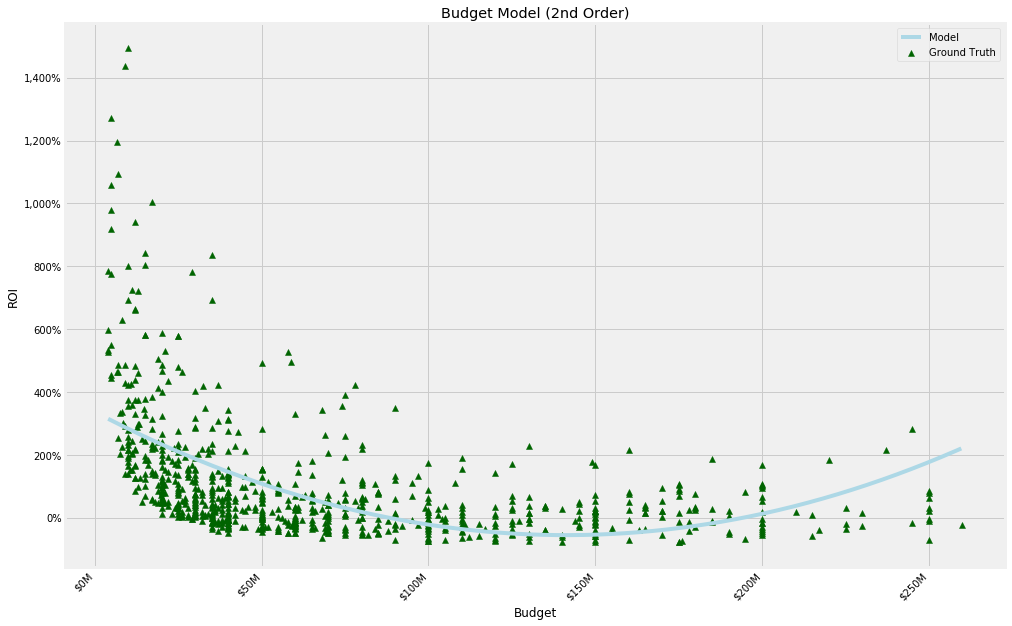

In [8]:
variable = 'budget'
degree = 2
X = df.loc[:, variable].values.reshape(-1, 1)
y = df.loc[:, 'roi']
X_train, X_test, y_train, y_test = train_test_split(X, y)
lr = Pipeline([('poly', PolynomialFeatures(degree)), 
               ('regr', LinearRegression())])
lr.fit(X_train, y_train)

X_linspace = linspace(X)
yhat = lr.predict(X_linspace)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.scatter(X, y, color='darkgreen', marker='^', label='Ground Truth')
ax.plot(X_linspace, yhat, color='lightblue', label='Model')
ax.legend()
ax.set(title='Budget Model (2nd Order)',
       xlabel='Budget',
       ylabel='ROI')
ax.xaxis.set_major_formatter(formatter)
ax.set_xticklabels(ax.get_xticks(), 
                   rotation=45, 
                   horizontalalignment='right')
ax.xaxis.set_major_formatter(formatter)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.show()

In [9]:
def plot_flexibility_curves(df, ivar):
    X = df.loc[:, ivar].values.reshape(-1, 1)
    y = df.loc[:, 'roi']
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    train_error = np.zeros(10)
    test_error = np.zeros(10)
    for degree in range(10):
        regr = Pipeline([('poly', PolynomialFeatures(degree)), 
                         ('regr', LinearRegression())])
        regr.fit(X_train, y_train)
        train_error[degree] = metrics.mean_squared_error(y_train, regr.predict(X_train))
        test_error[degree] = metrics.mean_squared_error(y_test, regr.predict(X_test))

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)
    ax.plot(np.arange(10), train_error, color='blue', label='Training MSE Curve')
    ax.plot(np.arange(10), test_error, color='green', label='Test MSE Curve')
    ax.set(title='{} Flexibility Curves'.format(ivar.title()), xlabel='Degree', ylabel='MSE')
    ax.set_xticks(range(10))
    ax.legend(loc='upper left')
    plt.show()

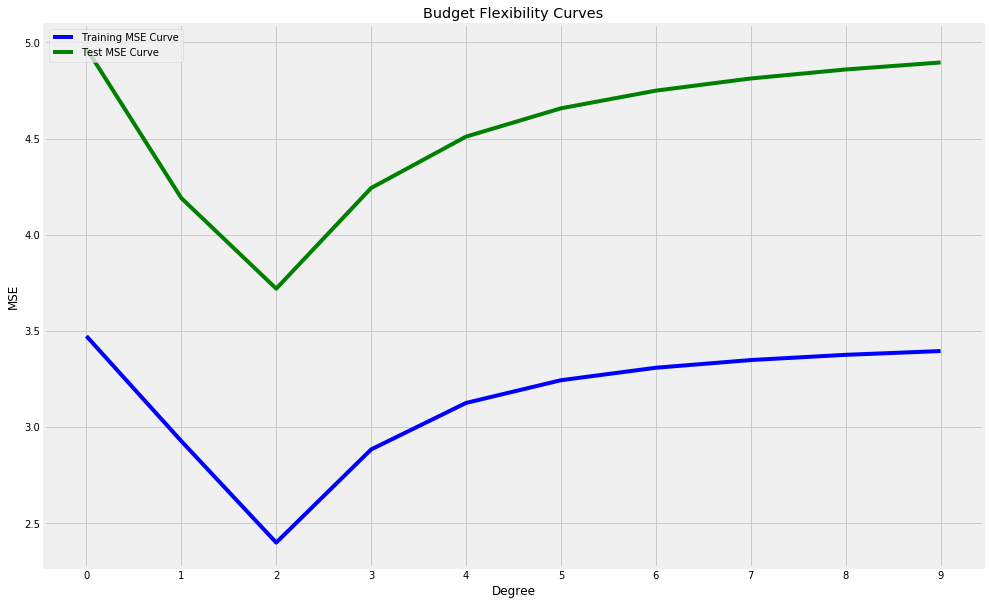

In [10]:
plot_flexibility_curves(df, 'budget')

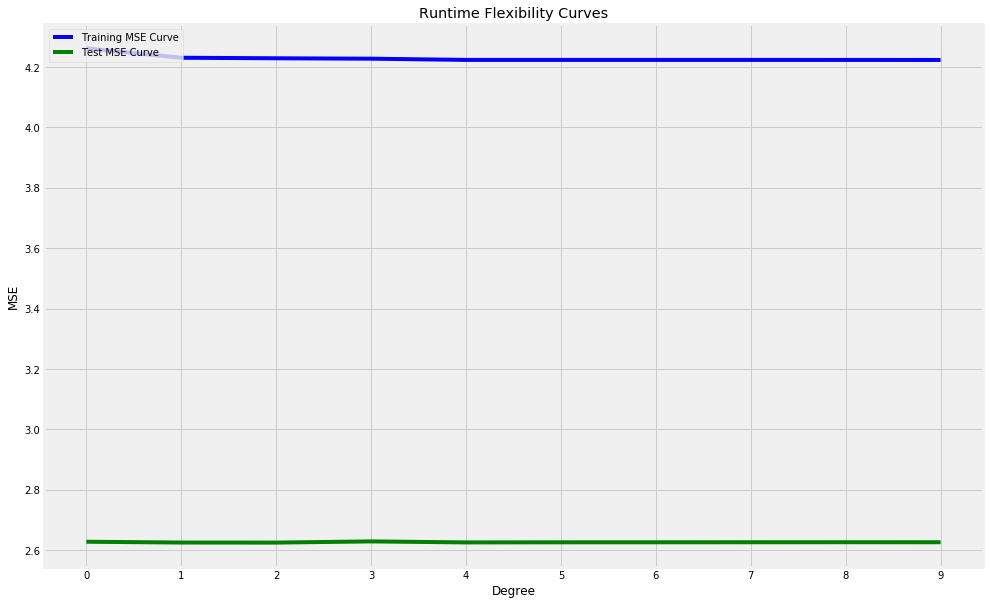

In [11]:
plot_flexibility_curves(df, 'runtime')

## Forward Selection

#### Budget (2nd Degree) and Days In Release

In [12]:
features = ['budget', 'in_release_days']
X = df.loc[:, features]
y = df.loc[:, ['roi']]


preprocessor = ColumnTransformer([
  ('budget', PolynomialFeatures(degree=2, include_bias=False), ['budget'])],
  remainder='passthrough')

regr = Pipeline([('preprocessor', preprocessor),
                 ('regressor', LinearRegression())])
lu.log_model(results, regr, X, y, features, degree)
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207
18,"[rating[T.PG], rating[T.PG-13], rating[T.R]]",1,0.029980,-0.044607,3.765328,1.940445
3,domestic_total_gross,1,0.022591,-0.004223,3.769902,1.941624
17,in_release_days,3,0.035290,-0.049908,3.772707,1.942346
16,in_release_days,2,0.035227,-0.060211,3.776756,1.943388
4,domestic_total_gross,2,0.027540,-0.025451,3.777060,1.943466


This gave us our best model yet. Let's see what else we can include to improve our model.

In [13]:
features = ['budget', 'in_release_days', 'rating']
X = df.loc[:, features]
y = df.loc[:, ['roi']]

preprocessor = ColumnTransformer([
  ('budget', PolynomialFeatures(degree=2, include_bias=False), ['budget']),
  ('rating', OneHotEncoder(drop='first'), ['rating'])],
  remainder='passthrough')

regr = Pipeline([('preprocessor', preprocessor),
                 ('regressor', LinearRegression())])
lu.log_model(results, regr, X, y, features, degree)
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
22,"[budget, in_release_days, rating]",2,0.374898,0.284969,2.482650,1.575643
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207
18,"[rating[T.PG], rating[T.PG-13], rating[T.R]]",1,0.029980,-0.044607,3.765328,1.940445
3,domestic_total_gross,1,0.022591,-0.004223,3.769902,1.941624
17,in_release_days,3,0.035290,-0.049908,3.772707,1.942346
16,in_release_days,2,0.035227,-0.060211,3.776756,1.943388


Rating doesn't give us much more so we'll scrape it.

In [14]:
features = ['budget', 'in_release_days', 'runtime']
X = df.loc[:, features]
y = df.loc[:, ['roi']]

preprocessor = ColumnTransformer([
  ('budget', PolynomialFeatures(degree=2, include_bias=False), ['budget'])],
  remainder='passthrough')

regr = Pipeline([('preprocessor', preprocessor),
                 ('regressor', LinearRegression())])
lu.log_model(results, regr, X, y, features, degree)
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
22,"[budget, in_release_days, rating]",2,0.374898,0.284969,2.482650,1.575643
23,"[budget, in_release_days, runtime]",2,0.376838,0.281193,2.484758,1.576312
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207
18,"[rating[T.PG], rating[T.PG-13], rating[T.R]]",1,0.029980,-0.044607,3.765328,1.940445
3,domestic_total_gross,1,0.022591,-0.004223,3.769902,1.941624
17,in_release_days,3,0.035290,-0.049908,3.772707,1.942346


Runtime doesn't help much either

In [15]:
features = ['budget', 'in_release_days', 'widest_release']
X = df.loc[:, features]
y = df.loc[:, ['roi']]

preprocessor = ColumnTransformer([
  ('budget', PolynomialFeatures(degree=2, include_bias=False), ['budget'])],
  remainder='passthrough')

regr = Pipeline([('preprocessor', preprocessor),
                 ('regressor', LinearRegression())])
lu.log_model(results, regr, X, y, features, degree)
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
24,"[budget, in_release_days, widest_release]",2,0.448287,0.357793,2.221206,1.490371
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
22,"[budget, in_release_days, rating]",2,0.374898,0.284969,2.482650,1.575643
23,"[budget, in_release_days, runtime]",2,0.376838,0.281193,2.484758,1.576312
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207
18,"[rating[T.PG], rating[T.PG-13], rating[T.R]]",1,0.029980,-0.044607,3.765328,1.940445
3,domestic_total_gross,1,0.022591,-0.004223,3.769902,1.941624


Now we're cooking! Adding widest release gets our test R-squared above a third!

Not great, but our best model so far. Let's try some others.

In [16]:
def my_tokenizer(doc):
    if doc.find(' / ') == -1:
        return doc.split(' ')
    else:
        return doc.split(' / ')

In [17]:
features = ['budget', 'in_release_days', 'widest_release', 'genre']
X = df.loc[:, features]
y = df.loc[:, ['roi']]

preprocessor = ColumnTransformer([
  ('budget', PolynomialFeatures(degree=2, include_bias=False), ['budget']),
  ('genre', CountVectorizer(tokenizer=my_tokenizer), 'genre')],
  remainder='passthrough')

regr = Pipeline([('preprocessor', preprocessor),
                 ('regressor', LinearRegression())])
lu.log_model(results, regr, X, y, features, degree=2)
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
24,"[budget, in_release_days, widest_release]",2,0.448287,0.357793,2.221206,1.490371
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
22,"[budget, in_release_days, rating]",2,0.374898,0.284969,2.482650,1.575643
23,"[budget, in_release_days, runtime]",2,0.376838,0.281193,2.484758,1.576312
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
25,"[budget, in_release_days, widest_release, genre]",2,0.074874,0.026740,3.580484,1.892217
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207
18,"[rating[T.PG], rating[T.PG-13], rating[T.R]]",1,0.029980,-0.044607,3.765328,1.940445


Genre really didn't do well for us. This is surprisingly. Let's try just horror as a dummy variable.

In [18]:
features = ['budget', 'in_release_days', 'widest_release', 'horror']
X = (df.assign(horror=lambda x: np.where(x.genre.str.contains('Horror'), 1, 0))
     .loc[:, features])
y = df.loc[:, ['roi']]

preprocessor = ColumnTransformer([
  ('budget', PolynomialFeatures(degree=2, include_bias=False), ['budget'])],
  remainder='passthrough')

regr = Pipeline([('preprocessor', preprocessor),
                 ('regressor', LinearRegression())])
lu.log_model(results, regr, X, y, features, degree=2)
results_df(results)

,features,degree,training_r2,test_r2,mse,rsme
24,"[budget, in_release_days, widest_release]",2,0.448287,0.357793,2.221206,1.490371
26,"[budget, in_release_days, widest_release, horror]",2,0.448286,0.357791,2.221211,1.490373
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
22,"[budget, in_release_days, rating]",2,0.374898,0.284969,2.482650,1.575643
23,"[budget, in_release_days, runtime]",2,0.376838,0.281193,2.484758,1.576312
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
25,"[budget, in_release_days, widest_release, genre]",2,0.074874,0.026740,3.580484,1.892217
15,in_release_days,1,0.029881,-0.028430,3.764404,1.940207


Horror did pretty well but still isn't beating our model with only _budget, days in release_ and _widest release_ !

## Regularized Model

Finally, let's throw all our features in one last model and use Lasso Regularization for some feature selection.

In [19]:
features = ['budget', 'in_release_days', 'widest_release', 'runtime', 'rating', 'genre']
X = df.loc[:, features]
y = df.loc[:, 'roi']

budget_poly = PolynomialFeatures(degree=2, include_bias=False)
budget_poly.fit(X.loc[:, ['budget']])
budget_df = pd.DataFrame(normalize(budget_poly.fit_transform(X.loc[:, ['budget']]), axis=0),
                         columns=[x.replace('x0', 'budget') for x in budget_poly.get_feature_names()])

ohe = OneHotEncoder(drop='first')
ohe.fit(X.loc[:, ['rating']])
columns = [x.replace('x0', 'rating') for x in ohe.get_feature_names()]
rating_df = pd.DataFrame(ohe.transform(X.loc[:, ['rating']]).toarray(),
                         columns=columns)

cv = CountVectorizer(tokenizer=my_tokenizer)
cv.fit(X.loc[:, 'genre'])
columns = cv.get_feature_names()
genre_df = pd.DataFrame(cv.transform(X.loc[:, 'genre']).toarray(),
                        columns=columns)

passthroughs = ['in_release_days', 'widest_release', 'runtime']
passthroughs_df = pd.DataFrame(normalize(df.loc[:, passthroughs],axis=0), columns=passthroughs)

frames = [budget_df, passthroughs_df, rating_df, genre_df]
X_trans = pd.concat(frames, axis=1)
X_trans.index = df.index

In [20]:
import warnings
warnings.filterwarnings("ignore")
kf = KFold(n_splits=5)
kf.get_n_splits(X)

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,100]


for train, test in kf.split(X):
    x_train = X_trans.iloc[train, :]
    y_train = y.iloc[train]
    x_test = X_trans.iloc[test, :]
    y_test = y.iloc[test]
    mse_score=[]
    for a in alphas:
        est = Lasso(alpha=a, max_iter=100000)
        est.fit(x_train,y_train)
        mse = np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

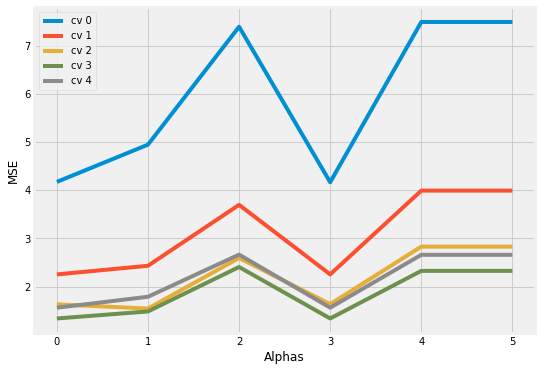

In [21]:
plt.figure(figsize=(8,6))
for i in range(5):
    plt.plot(all_scores[i], label='cv %s'%i)
plt.legend()
plt.xlabel('Alphas')
plt.ylabel('MSE')
plt.show()

In [22]:
# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.3)


X_trans.columns
regr = Lasso(alpha=1e-5)
lu.log_model(results, regr, X_trans, y, features='Regularized Model with All Columns', degree=2)

zipped=zip(X_trans.columns,np.abs(regr.coef_))
features= (pd.DataFrame(sorted(zipped, key=lambda x: x[1], reverse=True), columns=['Feature', 'Coefficient'])
           .set_index('Feature'))
features.head(10)

,Coefficient
Feature,
budget,175.591722
widest_release,113.475036
budget^2,92.013623
in_release_days,56.830876
runtime,21.784357
western,1.144278
concert,1.059412
horror,0.913868
crime,0.913629


In [23]:
results_df(results).rename(columns=lambda x: lu.format_cols(x, 'out'))

,Features,Degree,Training R2,Test R2,Mse,Rsme
27,Regularized Model with All Columns,2,0.508740,0.454241,2.136103,1.461541
24,"[budget, in_release_days, widest_release]",2,0.448287,0.357793,2.221206,1.490371
26,"[budget, in_release_days, widest_release, horror]",2,0.448286,0.357791,2.221211,1.490373
21,"[budget, in_release_days]",2,0.374899,0.284973,2.482646,1.575641
22,"[budget, in_release_days, rating]",2,0.374898,0.284969,2.482650,1.575643
23,"[budget, in_release_days, runtime]",2,0.376838,0.281193,2.484758,1.576312
1,budget,2,0.298164,0.221162,2.751055,1.658631
2,budget,3,0.162094,0.142412,3.235131,1.798647
0,budget,1,0.159838,0.107614,3.261668,1.806009
25,"[budget, in_release_days, widest_release, genre]",2,0.074874,0.026740,3.580484,1.892217


We got up to 45% of Variance explained with our Regularization Model! Good job us! 

We'll stop here but there are probably many other we could take this down like bringing in actors, movie studios, etc.